In [1]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, accuracy_score, recall_score, confusion_matrix,f1_score
from tensorflow import keras
import cv2
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input
from keras.applications.vgg16 import VGG16
import keras_tuner as kt
import tensorflow as tf
np.random.seed(42)
tf.random.set_seed(42)

<h3>Retrieving all the files name using glob.glob function<h3>

In [166]:
import glob

# Get all PNG images from both folders (0 and 1)
breast_img = glob.glob('Data_Organized/*/*.png', recursive=True)

print("Total images found:", len(breast_img))
breast_img[:5]  # preview first 5 image paths


Total images found: 4000


['Data_Organized\\0\\0_10253_0.png',
 'Data_Organized\\0\\0_10253_1.png',
 'Data_Organized\\0\\0_10253_10.png',
 'Data_Organized\\0\\0_10253_100.png',
 'Data_Organized\\0\\0_10253_101.png']

In [165]:
len(breast_img)

4000

In [163]:
breast_img[5:10]

['Data_Organized\\0\\0_10253_102.png',
 'Data_Organized\\0\\0_10253_103.png',
 'Data_Organized\\0\\0_10253_104.png',
 'Data_Organized\\0\\0_10253_105.png',
 'Data_Organized\\0\\0_10253_106.png']

## Extracting images in arrays of arrays format and equalizing the number of cancerous and non- cancerous


In [164]:
data=[]
label=[]
c=0
b=0
for i in breast_img:
      a=cv2.imread(i,cv2.IMREAD_COLOR)
      a=cv2.resize(a, (224, 224), interpolation = cv2.INTER_LINEAR)
      if i[-5]=='0' and b<=5000:
        label.append(0)
        data.append(a)
        b+=1
      elif  i[-5]=='1' and c<=5000:
        label.append(1)
        data.append(a) 
        c+=1
     
      if b>=5000 and c>=5000:
        break
        

KeyboardInterrupt: 

In [167]:
data=np.array(data)
label=np.array(label)

In [168]:
data = data.astype('float32') / 255.0

In [169]:
print("Min:", data[0].min(), "Max:", data[0].max())

Min: 0.15294118 Max: 0.9882353


<h4>Shape of our data<h4>

In [37]:
data.shape,label.shape

((1966, 224, 224, 3), (1966,))

In [38]:
data[0],label[0]

(array([[[188, 163, 216],
         [188, 163, 216],
         [187, 162, 215],
         ...,
         [185, 162, 230],
         [186, 163, 230],
         [186, 163, 230]],
 
        [[188, 163, 216],
         [188, 163, 216],
         [187, 162, 215],
         ...,
         [185, 162, 229],
         [186, 163, 230],
         [186, 163, 230]],
 
        [[188, 164, 216],
         [188, 164, 216],
         [188, 163, 215],
         ...,
         [184, 161, 230],
         [185, 162, 230],
         [185, 162, 230]],
 
        ...,
 
        [[173, 145, 218],
         [173, 145, 218],
         [172, 144, 217],
         ...,
         [177, 151, 229],
         [177, 152, 229],
         [177, 152, 229]],
 
        [[173, 145, 218],
         [173, 145, 218],
         [172, 144, 217],
         ...,
         [177, 151, 229],
         [178, 152, 229],
         [178, 152, 229]],
 
        [[173, 145, 218],
         [173, 145, 218],
         [172, 144, 217],
         ...,
         [177, 151, 229],
  

<h4>Number of cancerous and non-cancerous patients<h4>

In [39]:
unique_values, counts = np.unique(label, return_counts=True)
for i in range(len(counts)):
  print(unique_values[i],counts[i])

0 983
1 983


In [40]:
unique_values=['Non IDC','IDC']


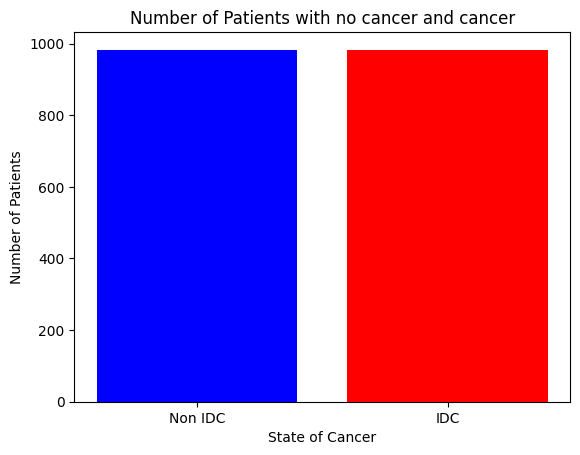

In [41]:
plt.bar(unique_values,counts,color=['Blue','red'])
# Adding labels and a title
plt.xlabel('State of Cancer')
plt.ylabel('Number of Patients')
plt.title('Number of Patients with no cancer and cancer')

# Display the bar chart
plt.show()

<h4>Display of some images data<h4>

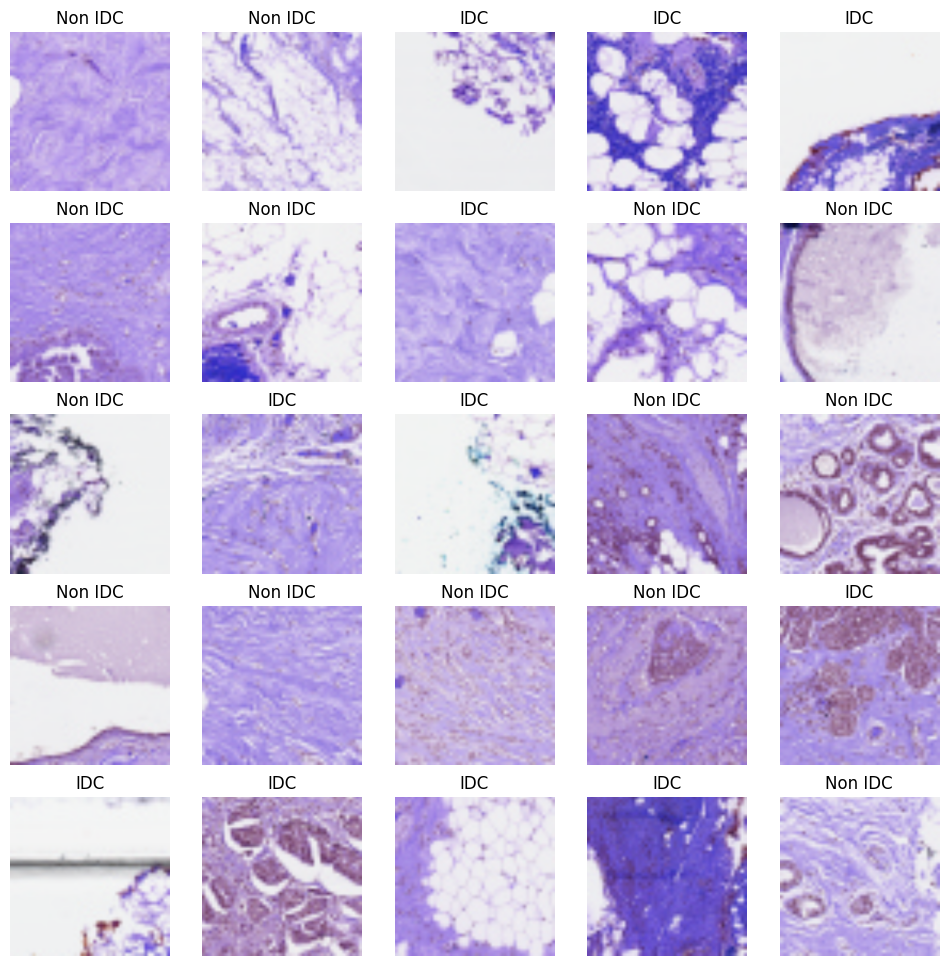

In [42]:
# Create a figure with 5 rows and 5 columns to display 25 images
sh = np.random.randint(0, len(label),25)
fig = plt.figure(figsize=(12, 12))
s=1
for i in sh:
    plt.subplot(5, 5, s)
    plt.imshow(data[i])
    if label[i]==0:
     plt.title('Non IDC')
    else:
     plt.title('IDC')
    plt.axis('off')
    s+=1


# Show the plot
plt.show()

<h4>Splitting the data into test and train<h4>

In [43]:
x_train,x_test,y_train,y_test=train_test_split(data,label,random_state=78,test_size=0.25)

In [44]:
unique_values, counts = np.unique(y_test, return_counts=True)
for i in range(len(counts)):
  print(unique_values[i],counts[i])

0 256
1 236


In [45]:
x_test.shape,y_train.shape


((492, 224, 224, 3), (1474,))

<h4> Converting categorical data into a one-hot encoded format,One-hot encoding is a way to represent categorical variables with binary vectors.<h4>

In [46]:
y_train=tf.one_hot(y_train,2)
y_test=tf.one_hot(y_test,2)

In [47]:
y_train

<tf.Tensor: shape=(1474, 2), dtype=float32, numpy=
array([[1., 0.],
       [0., 1.],
       [1., 0.],
       ...,
       [0., 1.],
       [1., 0.],
       [0., 1.]], dtype=float32)>

## Using ResNet50 to improve accuracy

### Preprocessing data for our model

In [10]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Data after preprocessing

In [31]:
train_dir = "dataset/train"
val_dir = "dataset/val"


In [32]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    "dataset/train",
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    "dataset/val",
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)


Found 6400 images belonging to 2 classes.
Found 1600 images belonging to 2 classes.


In [33]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
base_model.trainable = False  # freeze base

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_4[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,589,761 (89.99 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
# Unfreeze last 40 layers for fine-tuning
for layer in base_model.layers[-40:]:
    layer.trainable = True

# Re-compile with lower learning rate
model.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history_finetuned = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[early_stop]
)


Epoch 1/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 451s 2s/step - accuracy: 0.6747 - loss: 0.5993 - val_accuracy: 0.5281 - val_loss: 0.6880
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 451s 2s/step - accuracy: 0.7591 - loss: 0.5129 - val_accuracy: 0.7538 - val_loss: 0.5176
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 445s 2s/step - accuracy: 0.7583 - loss: 0.5040 - val_accuracy: 0.7669 - val_loss: 0.4914
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 541s 3s/step - accuracy: 0.7780 - loss: 0.4695 - val_accuracy: 0.6356 - val_loss: 0.8123
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 670s 3s/step - accuracy: 0.7902 - loss: 0.4571 - val_accuracy: 0.5094 - val_loss: 1.5655
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 647s 3s/step - accuracy: 0.8023 - loss: 0.4424 - val_accuracy: 0.5000 - val_loss: 4.5635


3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step


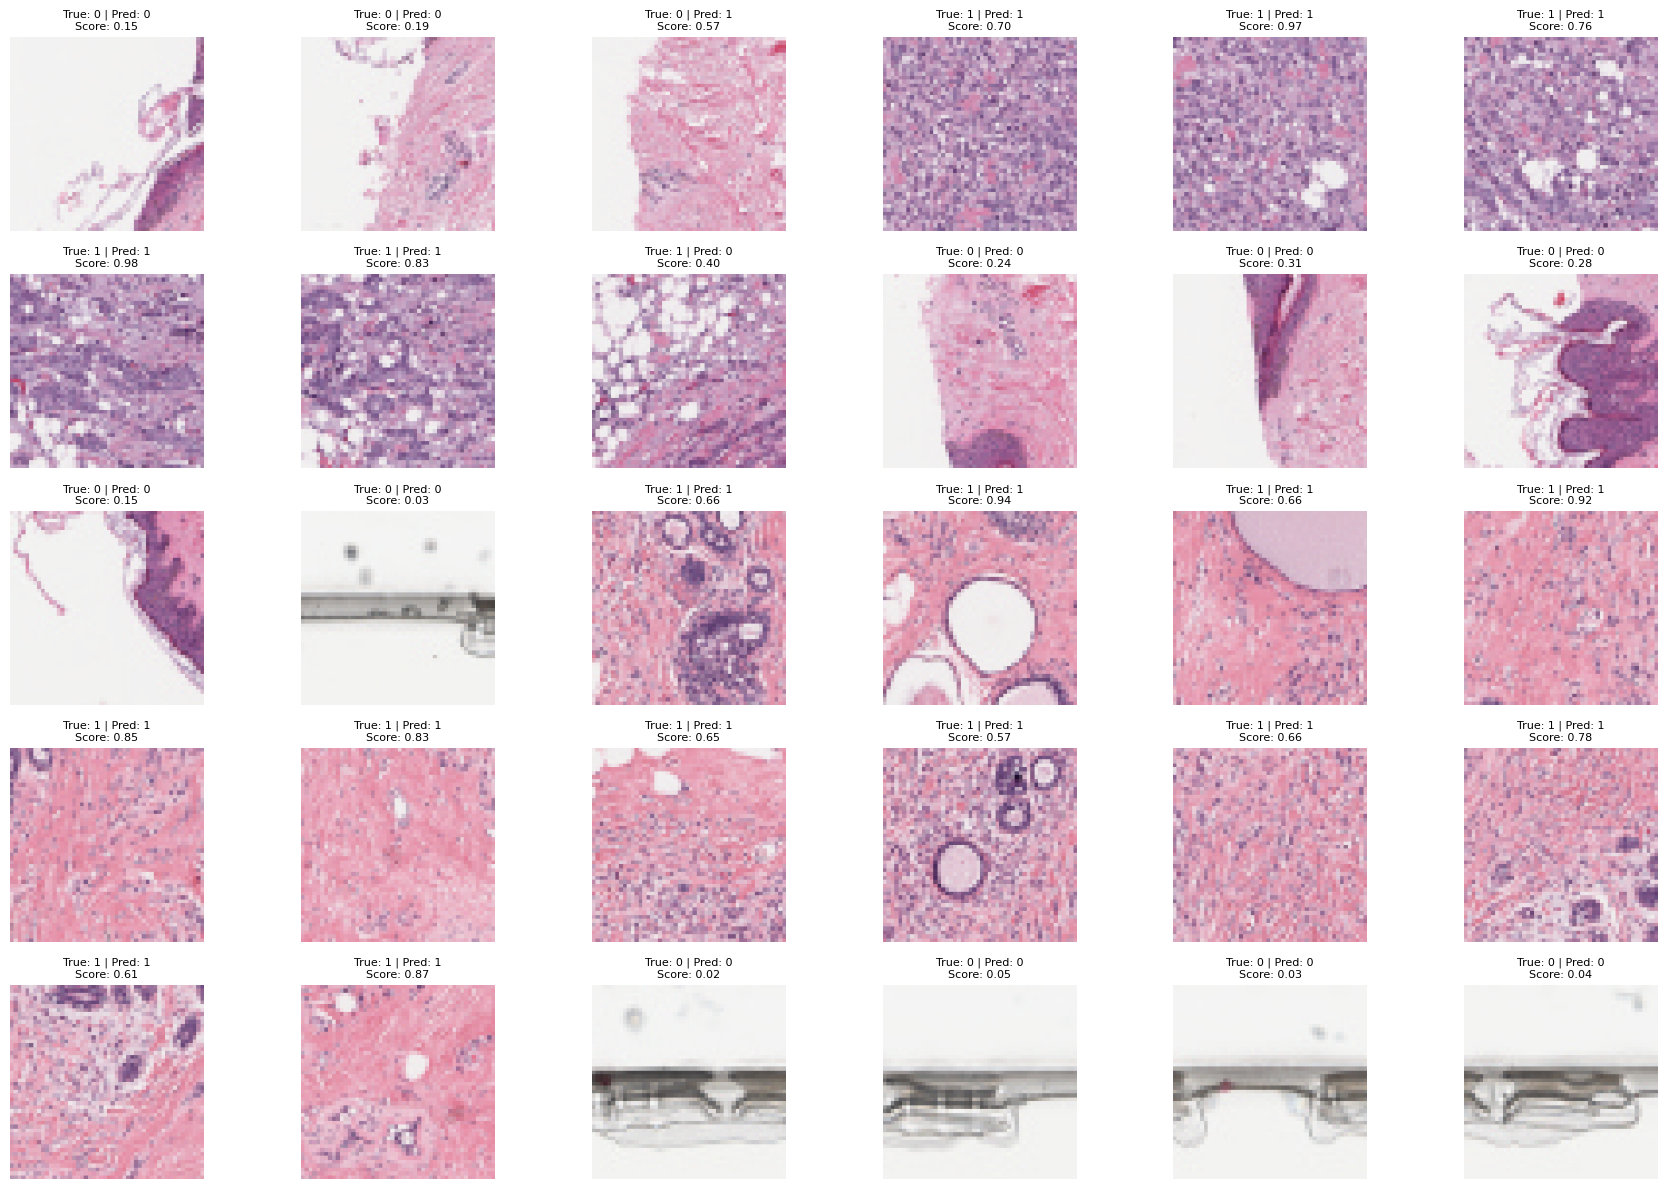

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img, img_to_array

# Path to test image directory
test_dir = "C:/Users/Lenovo/Desktop/Breast-Cancer-detection-main/test images"
img_size = (224, 224)

# Load and preprocess test images
test_images = []
true_labels = []
file_names = []

for file in os.listdir(test_dir):
    if file.lower().endswith((".png", ".jpg", ".jpeg")):
        path = os.path.join(test_dir, file)
        img = load_img(path, target_size=img_size)
        img_array = img_to_array(img) / 255.0
        test_images.append(img_array)
        file_names.append(file)
        # Extract true label from filename like '...class1.png'
        label = 1 if "class1" in file else 0
        true_labels.append(label)

test_images = np.array(test_images)
true_labels = np.array(true_labels)

# Predict
pred_probs = model.predict(test_images)
pred_classes = (pred_probs > 0.5).astype("int32").flatten()

# Plot
plt.figure(figsize=(18, 12))
for idx in range(min(30, len(test_images))):
    plt.subplot(5, 6, idx + 1)
    plt.imshow(test_images[idx])
    plt.axis('off')
    plt.title(f"True: {true_labels[idx]} | Pred: {pred_classes[idx]}\nScore: {pred_probs[idx][0]:.2f}", fontsize=8)
plt.tight_layout()
plt.show()


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step


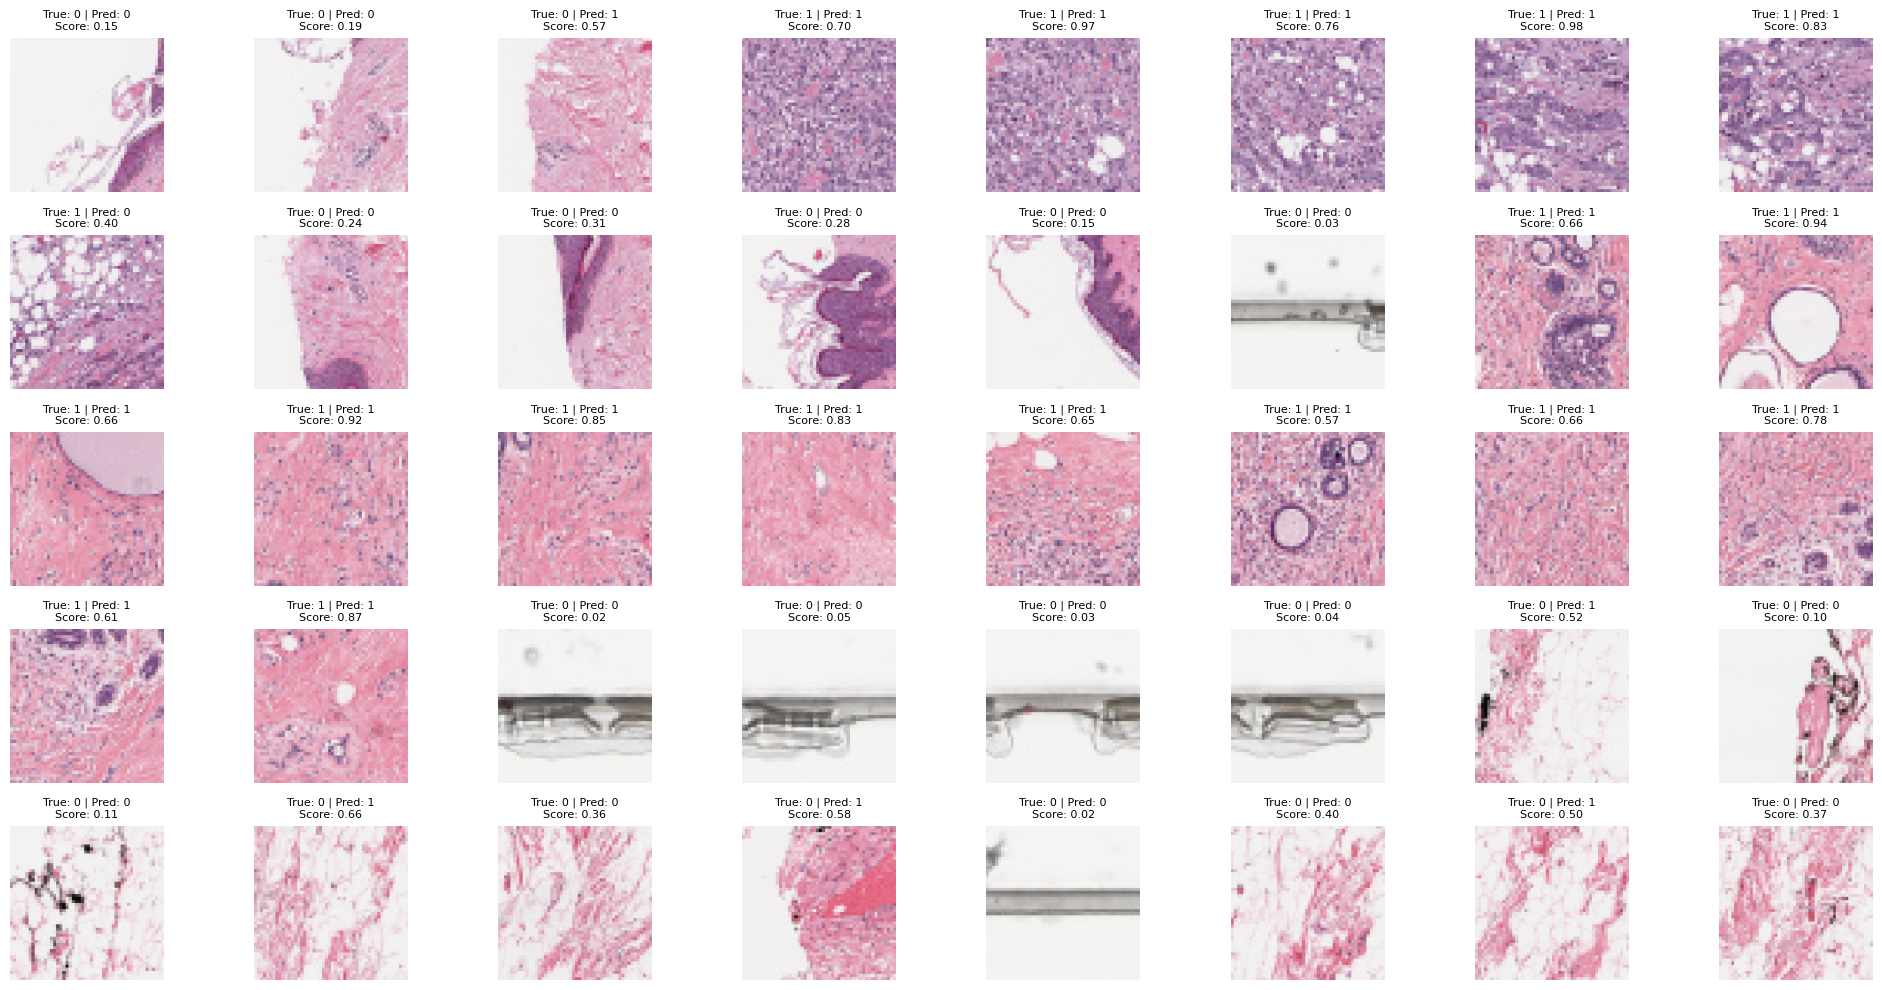

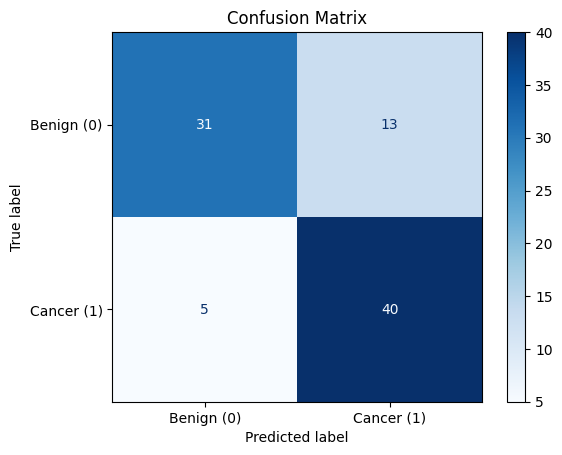

📊 Classification Report:
              precision    recall  f1-score   support

  Benign (0)       0.86      0.70      0.78        44
  Cancer (1)       0.75      0.89      0.82        45

    accuracy                           0.80        89
   macro avg       0.81      0.80      0.80        89
weighted avg       0.81      0.80      0.80        89

✅ Accuracy: 0.7978


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# === Load test images ===
test_dir = "C:/Users/Lenovo/Desktop/Breast-Cancer-detection-main/test images"
img_size = (224, 224)
test_images = []
file_names = []

for file in os.listdir(test_dir):
    if file.lower().endswith(".png"):
        path = os.path.join(test_dir, file)
        img = load_img(path, target_size=img_size)
        img_array = img_to_array(img) / 255.0
        test_images.append(img_array)
        file_names.append(file)

test_images = np.array(test_images)

# === Extract true labels from filenames ===
true_labels = [1 if "class1" in name.lower() else 0 for name in file_names]

# === Predict ===
pred_probs = model.predict(test_images)
pred_classes = (pred_probs > 0.5).astype("int32").flatten()

# === Plot sample images with predictions ===
plt.figure(figsize=(20, 10))
for idx in range(min(len(test_images), 40)):
    plt.subplot(5, 8, idx + 1)
    plt.imshow(test_images[idx])
    plt.axis("off")
    plt.title(f"True: {true_labels[idx]} | Pred: {pred_classes[idx]}\nScore: {pred_probs[idx][0]:.2f}", fontsize=8)
plt.tight_layout()
plt.show()

# === Confusion matrix ===
cm = confusion_matrix(true_labels, pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Benign (0)", "Cancer (1)"])
disp.plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix")
plt.show()

# === Classification report ===
print("📊 Classification Report:")
print(classification_report(true_labels, pred_classes, target_names=["Benign (0)", "Cancer (1)"]))

# === Accuracy ===
acc = accuracy_score(true_labels, pred_classes)
print(f"✅ Accuracy: {acc:.4f}")


mobilenet

In [35]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns



In [36]:
# Paths to your datasets
train_dir = "dataset/train"
val_dir = "dataset/val"
test_dir = "test images"


In [37]:
# Training with strong augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

# Validation and Test (only rescale)
val_datagen = ImageDataGenerator(rescale=1./255)

# Load
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)


Found 6400 images belonging to 2 classes.
Found 1600 images belonging to 2 classes.


In [38]:
# Load MobileNetV2
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze

# Add custom head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)

# Final model
model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_5[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [39]:
# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Checkpoint
checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True)

# Train
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[early_stop, checkpoint]
)


c:\Users\Lenovo\Desktop\Breast-Cancer-detection-main\venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 763ms/step - accuracy: 0.6982 - loss: 0.5777

200/200 ━━━━━━━━━━━━━━━━━━━━ 181s 889ms/step - accuracy: 0.6986 - loss: 0.5772 - val_accuracy: 0.8494 - val_loss: 0.3747
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 709ms/step - accuracy: 0.8271 - loss: 0.3979

200/200 ━━━━━━━━━━━━━━━━━━━━ 186s 806ms/step - accuracy: 0.8272 - loss: 0.3979 - val_accuracy: 0.8669 - val_loss: 0.3457
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 736ms/step - accuracy: 0.8429 - loss: 0.3713

200/200 ━━━━━━━━━━━━━━━━━━━━ 170s 849ms/step - accuracy: 0.8429 - loss: 0.3713 - val_accuracy: 0.8700 - val_loss: 0.3385
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 823ms/step - accuracy: 0.8493 - loss: 0.3538

200/200 ━━━━━━━━━━━━━━━━━━━━ 185s 927ms/step - accuracy: 0.8493 - loss: 0.3538 - val_accuracy: 0.8731 - val_loss: 0.3372
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 774ms/step - accuracy: 0.8631 - loss: 0.3249

200/200 ━━━━━━━━━━━━━━━━━━━━ 176s 881ms/step - accuracy: 0.8631 - loss: 0.3250 - val_accuracy: 0.8775 - val_loss: 0.3320
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 773ms/step - accuracy: 0.8629 - loss: 0.3280

200/200 ━━━━━━━━━━━━━━━━━━━━ 175s 876ms/step - accuracy: 0.8629 - loss: 0.3281 - val_accuracy: 0.8744 - val_loss: 0.3275
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 728ms/step - accuracy: 0.8564 - loss: 0.3286

200/200 ━━━━━━━━━━━━━━━━━━━━ 166s 832ms/step - accuracy: 0.8564 - loss: 0.3286 - val_accuracy: 0.8756 - val_loss: 0.3253
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 731ms/step - accuracy: 0.8563 - loss: 0.3365

200/200 ━━━━━━━━━━━━━━━━━━━━ 166s 831ms/step - accuracy: 0.8563 - loss: 0.3365 - val_accuracy: 0.8863 - val_loss: 0.3127
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 679ms/step - accuracy: 0.8574 - loss: 0.3342

200/200 ━━━━━━━━━━━━━━━━━━━━ 158s 788ms/step - accuracy: 0.8574 - loss: 0.3342 - val_accuracy: 0.8856 - val_loss: 0.3127
Epoch 10/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 172s 861ms/step - accuracy: 0.8621 - loss: 0.3144 - val_accuracy: 0.8794 - val_loss: 0.3222


In [43]:
# Unfreeze last 50 layers
for layer in base_model.layers[-50:]:
    layer.trainable = True

# Recompile with smaller learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Fine-tune
history_fine = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[early_stop, checkpoint]
)


Epoch 1/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 742ms/step - accuracy: 0.7797 - loss: 0.5832

200/200 ━━━━━━━━━━━━━━━━━━━━ 177s 851ms/step - accuracy: 0.7799 - loss: 0.5827 - val_accuracy: 0.8781 - val_loss: 0.3099
Epoch 2/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 776ms/step - accuracy: 0.8301 - loss: 0.4089

200/200 ━━━━━━━━━━━━━━━━━━━━ 176s 880ms/step - accuracy: 0.8302 - loss: 0.4087 - val_accuracy: 0.8806 - val_loss: 0.2999
Epoch 3/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 761ms/step - accuracy: 0.8646 - loss: 0.3383

200/200 ━━━━━━━━━━━━━━━━━━━━ 173s 864ms/step - accuracy: 0.8645 - loss: 0.3383 - val_accuracy: 0.8819 - val_loss: 0.2981
Epoch 4/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 237s 1s/step - accuracy: 0.8680 - loss: 0.3150 - val_accuracy: 0.8794 - val_loss: 0.3118
Epoch 5/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 234s 1s/step - accuracy: 0.8738 - loss: 0.3068 - val_accuracy: 0.8719 - val_loss: 0.3194
Epoch 6/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 220s 1s/step - accuracy: 0.8853 - loss: 0.2865 - val_accuracy: 0.8669 - val_loss: 0.3280
Epoch 7/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 173s 864ms/step - accuracy: 0.8822 - loss: 0.2916 - val_accuracy: 0.8625 - val_loss: 0.3584
Epoch 8/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 172s 861ms/step - accuracy: 0.8871 - loss: 0.2738 - val_accuracy: 0.8737 - val_loss: 0.3065


In [44]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Set test image path
test_dir = "C:/Users/Lenovo/Desktop/Breast-Cancer-detection-main/test images"
img_size = (224, 224)

test_images = []
file_names = []

# Load and preprocess images
for file in os.listdir(test_dir):
    if file.endswith(".png") or file.endswith(".jpg") or file.endswith(".jpeg"):
        path = os.path.join(test_dir, file)
        img = load_img(path, target_size=img_size)
        img_array = img_to_array(img) / 255.0  # normalize
        test_images.append(img_array)
        file_names.append(file)

test_images = np.array(test_images)


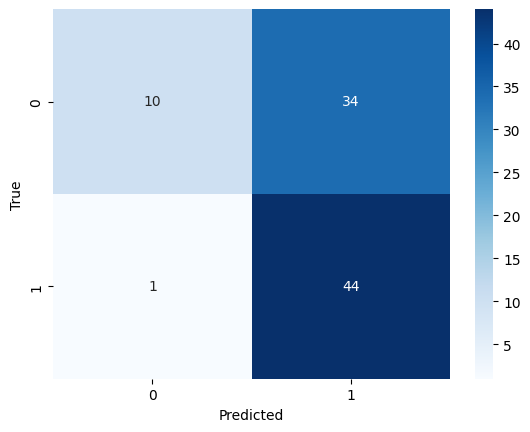

              precision    recall  f1-score   support

           0       0.91      0.23      0.36        44
           1       0.56      0.98      0.72        45

    accuracy                           0.61        89
   macro avg       0.74      0.60      0.54        89
weighted avg       0.73      0.61      0.54        89



In [45]:
# Confusion Matrix
cm = confusion_matrix(true_labels, pred_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification Report
print(classification_report(true_labels, pred_labels))


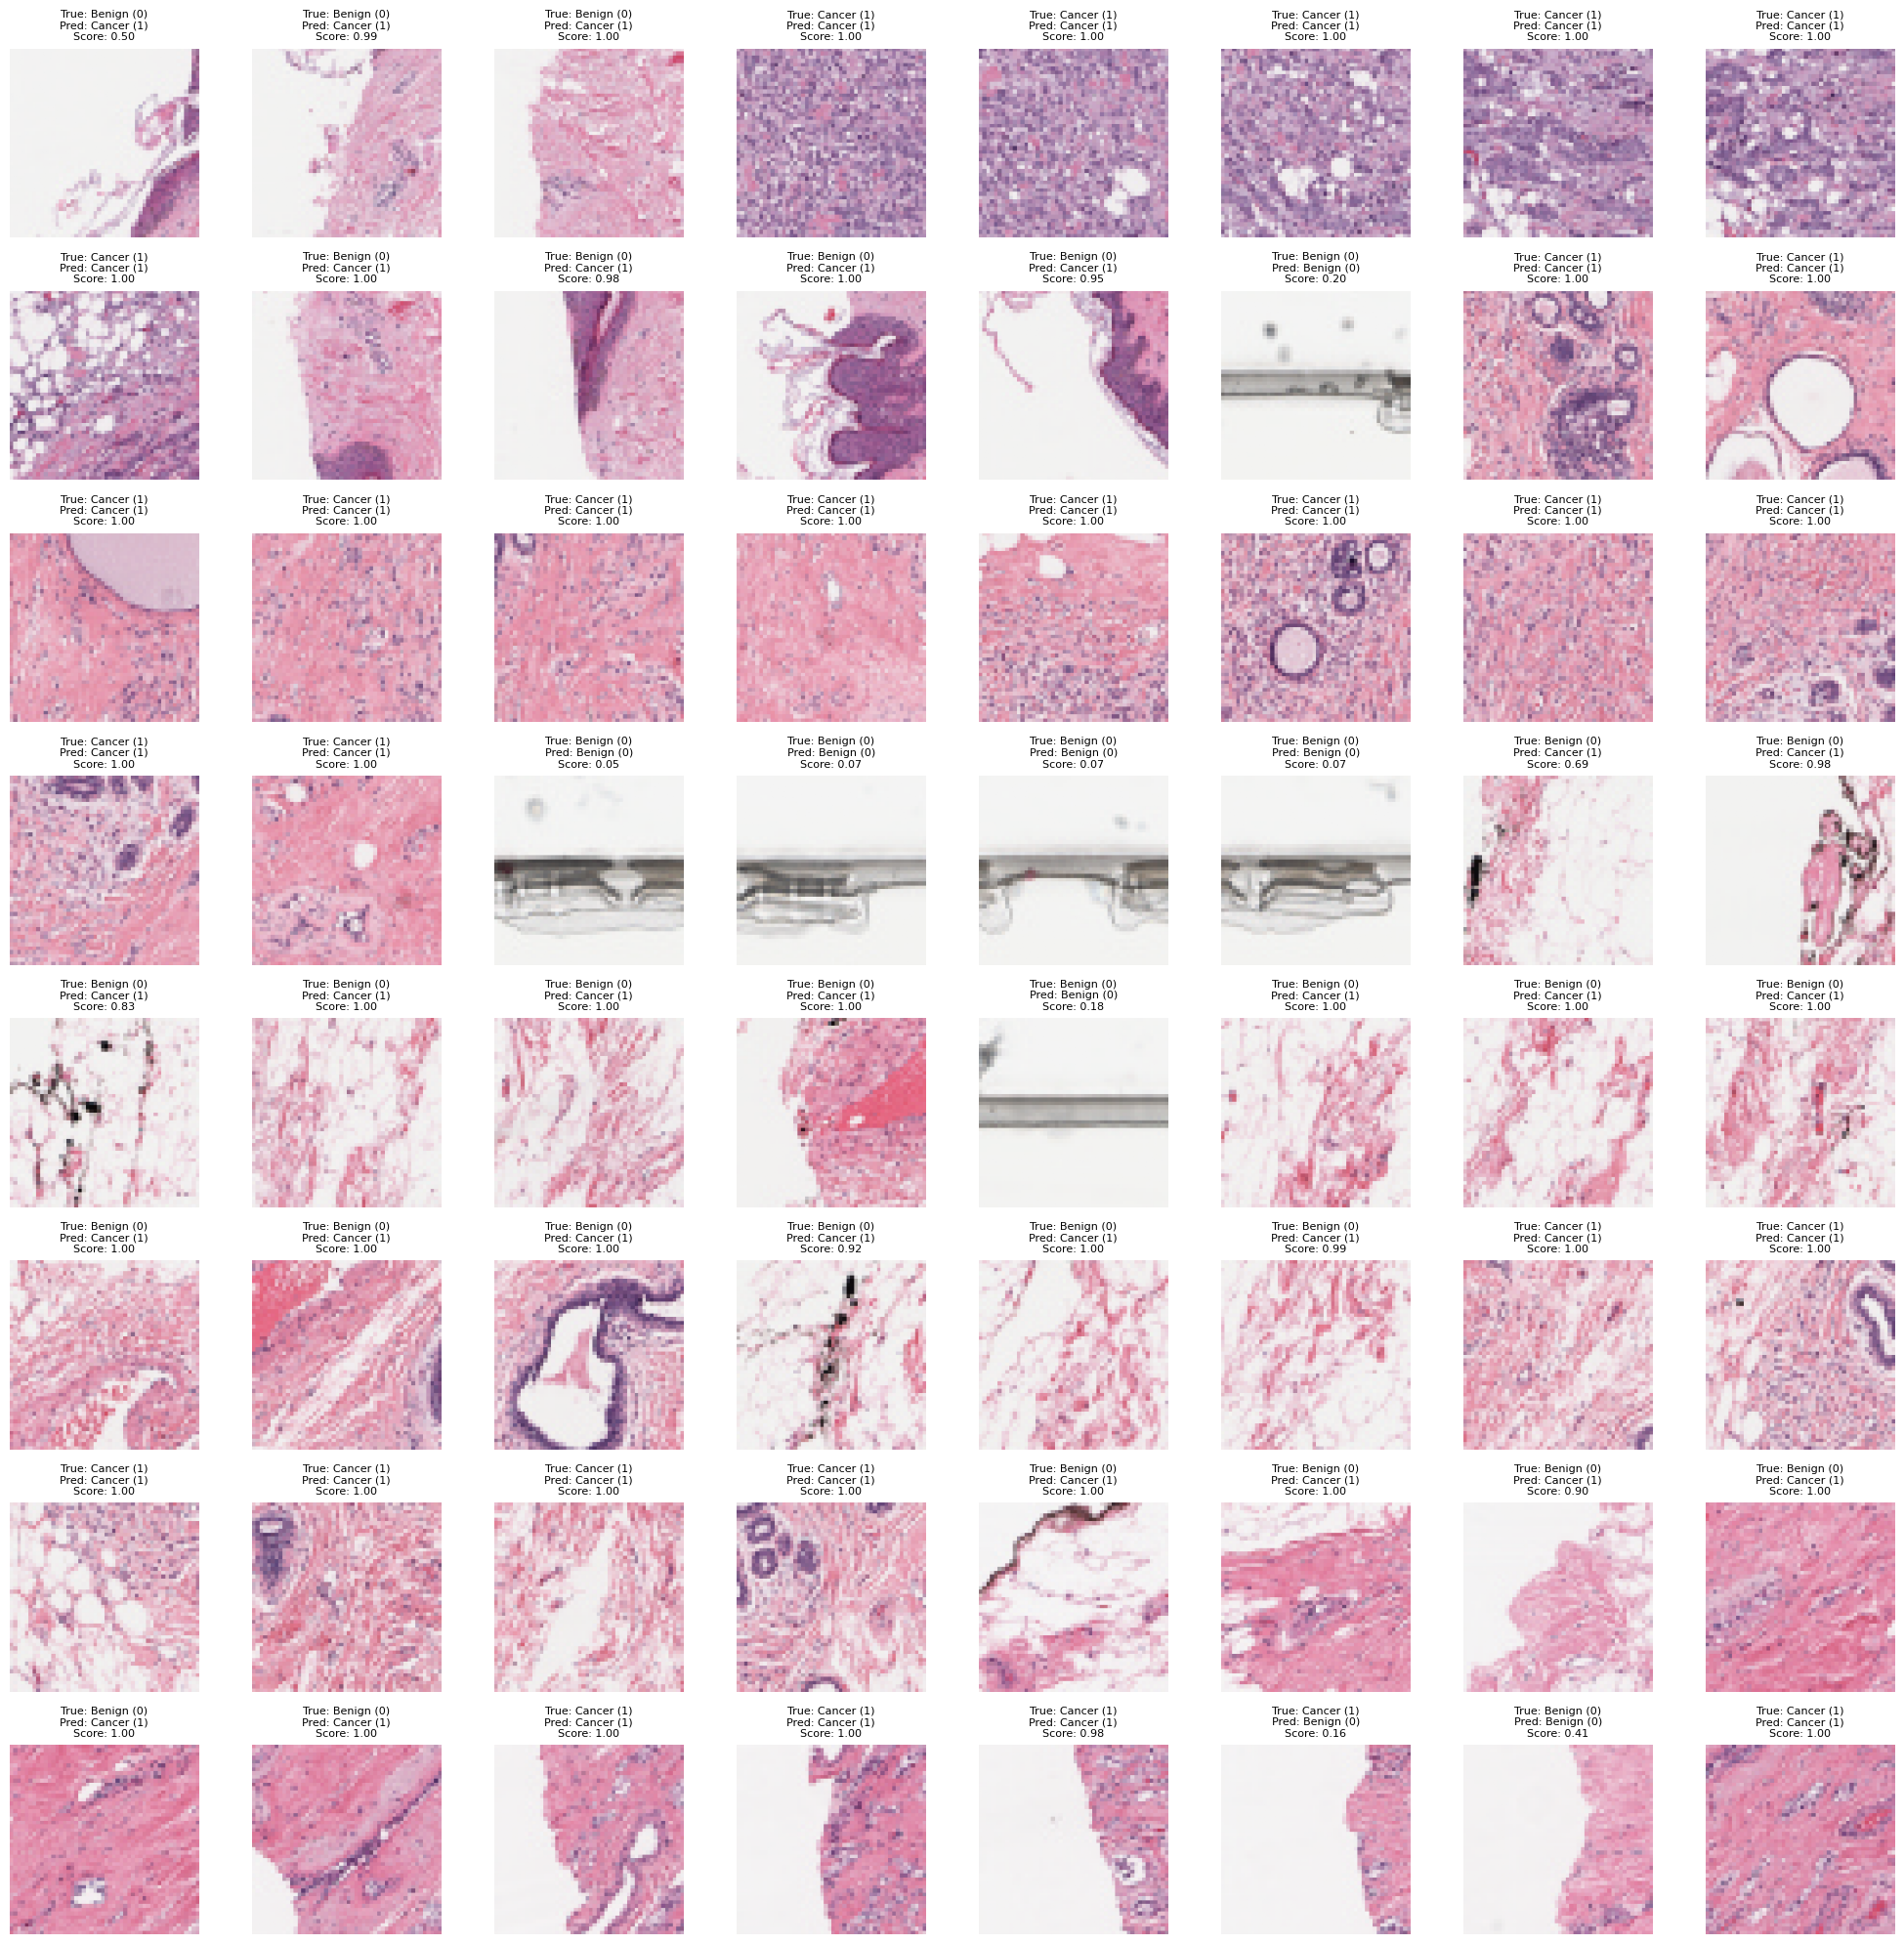

In [46]:
# Plot images with True and Predicted labels
plt.figure(figsize=(20, 20))
for idx in range(min(64, len(test_images))):  # limit to 64 images
    plt.subplot(8, 8, idx + 1)
    plt.imshow(test_images[idx])
    true_class = 'Cancer (1)' if true_labels[idx] == 1 else 'Benign (0)'
    pred_class = 'Cancer (1)' if pred_labels[idx] == 1 else 'Benign (0)'
    plt.title(f"True: {true_class}\nPred: {pred_class}\nScore: {pred_probs[idx][0]:.2f}", fontsize=8)
    plt.axis('off')
plt.tight_layout()
plt.show()


custom cnn

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3), kernel_regularizer=l2(0.001)),
    MaxPooling2D(2, 2),
    BatchNormalization(),

    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling2D(2, 2),
    BatchNormalization(),
    Dropout(0.4),

    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling2D(2, 2),
    BatchNormalization(),
    Dropout(0.4),

    Flatten(),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])


In [ ]:
model.compile(
    optimizer=Adam(learning_rate=1e-4),  # Lower learning rate
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 111, 111, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 54, 54, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 26, 26, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │     5,537,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,632,065 (21.48 MB)

 Trainable params: 5,631,617 (21.48 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.7, 1.3],
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    'dataset/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    'dataset/val',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)


Found 6400 images belonging to 2 classes.
Found 1600 images belonging to 2 classes.


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[early_stop]
)



Epoch 1/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 226s 1s/step - accuracy: 0.7691 - loss: 1.2076 - val_accuracy: 0.6169 - val_loss: 0.9209
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 249s 1s/step - accuracy: 0.8059 - loss: 0.9638 - val_accuracy: 0.5006 - val_loss: 1.0473
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 204s 1s/step - accuracy: 0.8237 - loss: 0.8989 - val_accuracy: 0.5219 - val_loss: 1.3162
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 205s 1s/step - accuracy: 0.8187 - loss: 0.9171 - val_accuracy: 0.8656 - val_loss: 0.6479
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 202s 1s/step - accuracy: 0.8241 - loss: 0.8484 - val_accuracy: 0.8350 - val_loss: 0.7053
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 186s 929ms/step - accuracy: 0.8352 - loss: 0.7588 - val_accuracy: 0.8225 - val_loss: 0.6451
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 182s 910ms/step - accuracy: 0.8437 - loss: 0.7589 - val_accuracy: 0.8687 - val_loss: 0.5872
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 182s 911ms/step - accuracy: 0.8374 - loss: 0.6942 -

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import classification_report

test_dir = r"C:\Users\Lenovo\Desktop\Breast-Cancer-detection-main\test images"
img_size = (224, 224)

test_images = []
true_labels = []
file_names = []

# Load images and extract true labels from filename
for file in os.listdir(test_dir):
    if file.lower().endswith(('.png', '.jpg', '.jpeg')):
        path = os.path.join(test_dir, file)
        img = load_img(path, target_size=img_size)
        img_array = img_to_array(img) / 255.0
        test_images.append(img_array)
        file_names.append(file)

        # Extract true label from filename like: ..._class0.png
        if "_class0" in file:
            true_labels.append(0)
        elif "_class1" in file:
            true_labels.append(1)

test_images = np.array(test_images)
true_labels = np.array(true_labels)

# Predict
pred_probs = model.predict(test_images)
pred_labels = (pred_probs > 0.5).astype(int).flatten()


2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/stepWARNING:tensorflow:6 out of the last 9 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000021D4584AE50> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 173ms/step


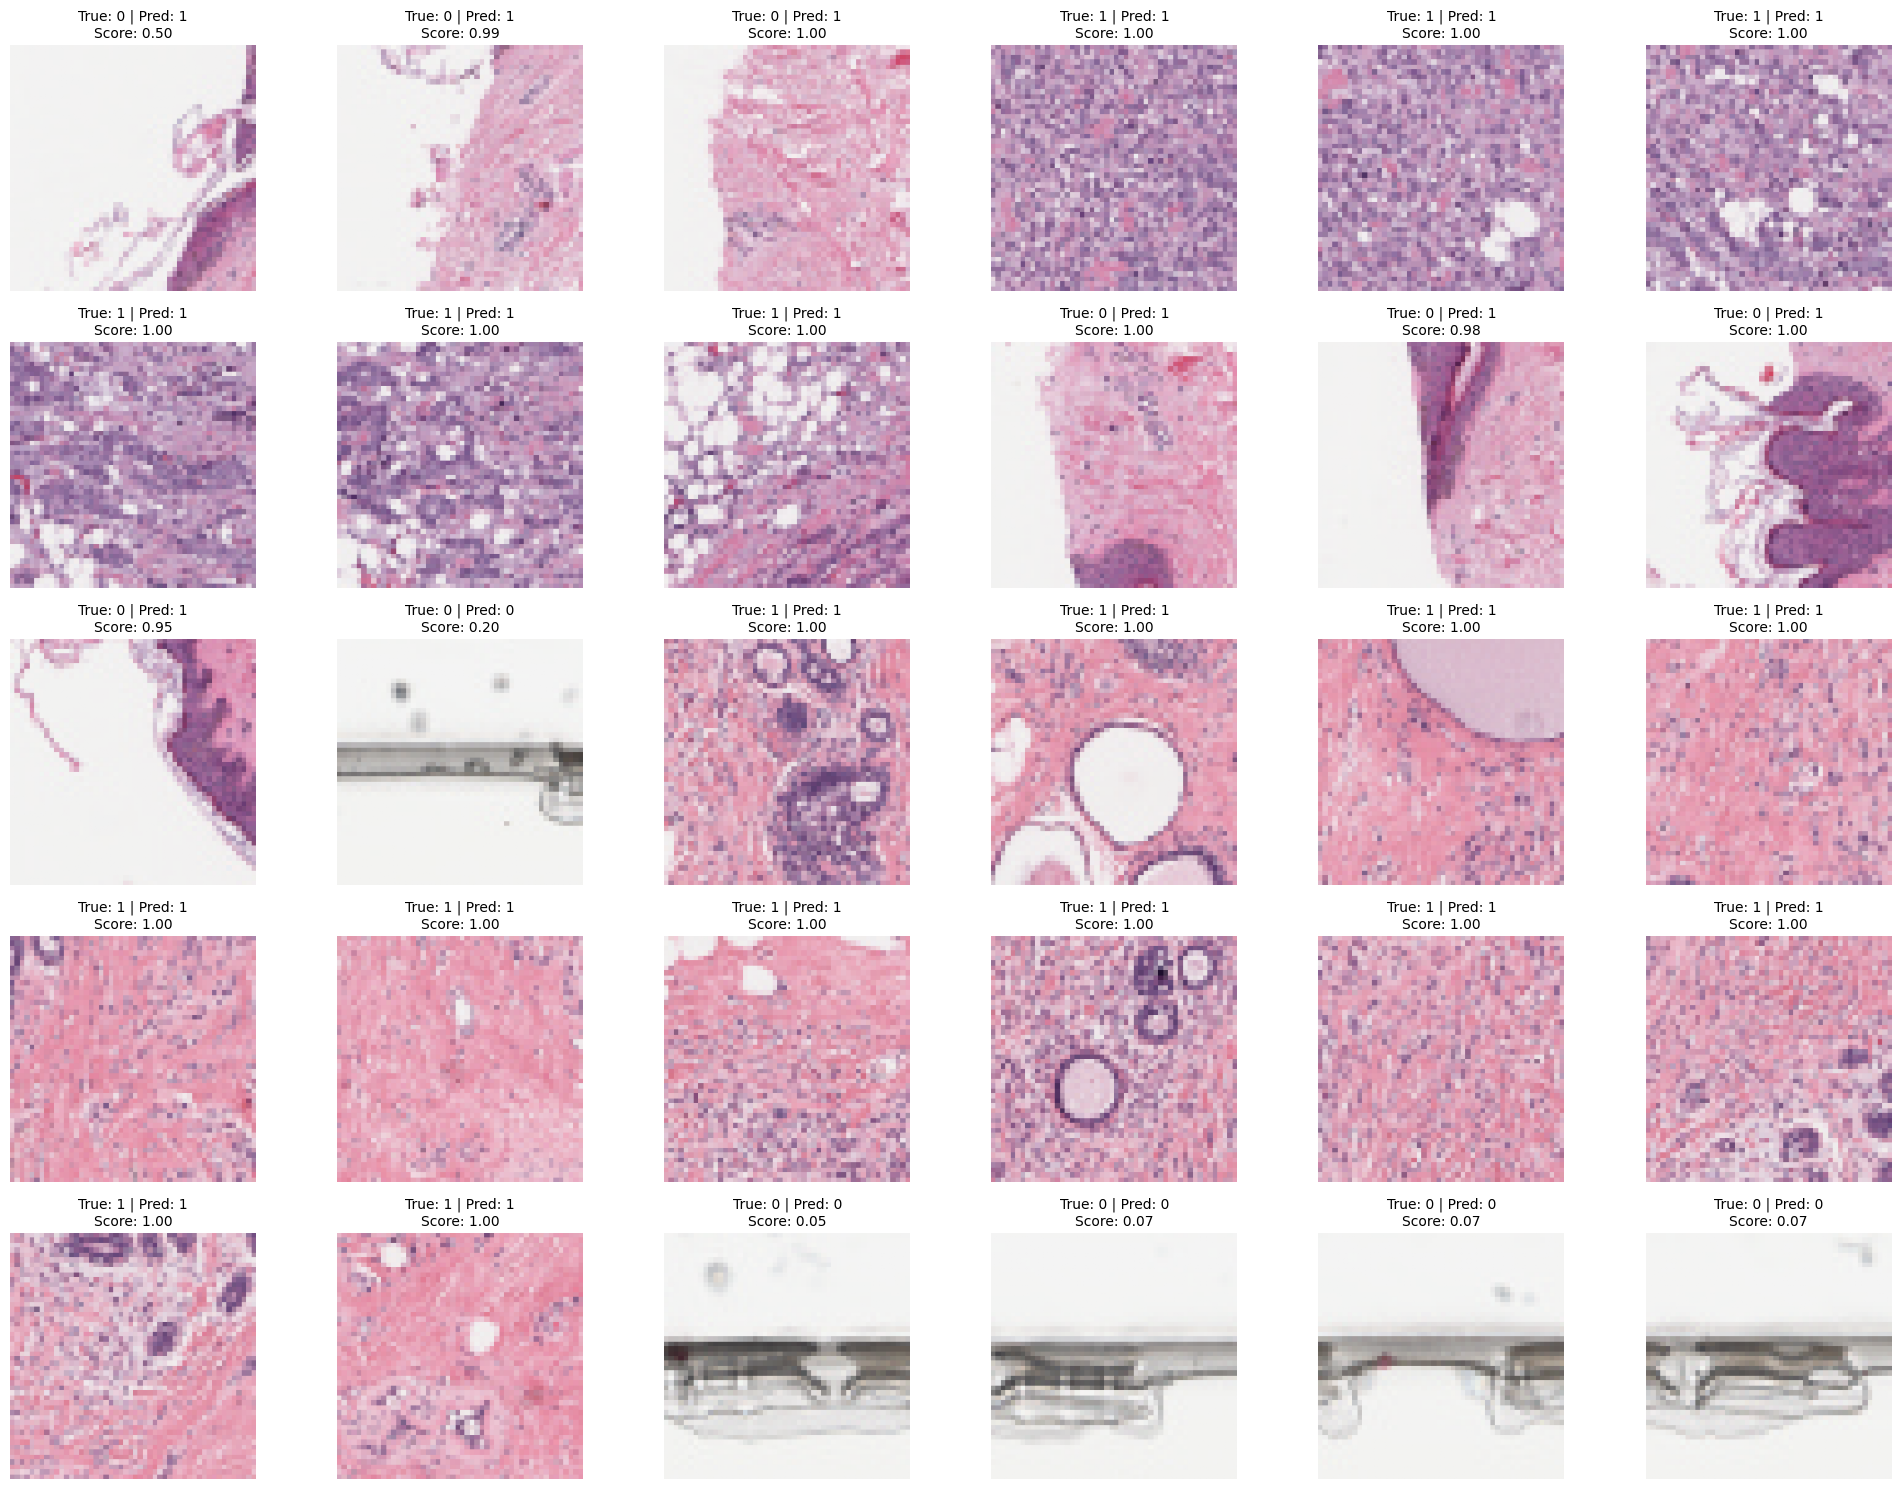

              precision    recall  f1-score   support

  Benign (0)       0.91      0.23      0.36        44
  Cancer (1)       0.56      0.98      0.72        45

    accuracy                           0.61        89
   macro avg       0.74      0.60      0.54        89
weighted avg       0.73      0.61      0.54        89



In [ ]:
# Plot the predictions
plt.figure(figsize=(20, 15))
for i in range(min(30, len(test_images))):  # Show first 30
    plt.subplot(5, 6, i + 1)
    plt.imshow(test_images[i])
    plt.axis('off')
    plt.title(f"True: {true_labels[i]} | Pred: {pred_labels[i]}\nScore: {pred_probs[i][0]:.2f}", fontsize=10)
plt.tight_layout()
plt.show()

# Print classification report
from sklearn.metrics import classification_report
print(classification_report(true_labels, pred_labels, target_names=["Benign (0)", "Cancer (1)"]))


DenseNet


In [55]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load base model
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the backbone

# Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

# Compile
model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])




29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 16s 1us/step


In [58]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    'dataset/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

val_gen = val_datagen.flow_from_directory(
    'dataset/val',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)




Found 6400 images belonging to 2 classes.
Found 1600 images belonging to 2 classes.


In [59]:
model.fit(train_gen, validation_data=val_gen, epochs=10)

Epoch 1/10


c:\Users\Lenovo\Desktop\Breast-Cancer-detection-main\venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


200/200 ━━━━━━━━━━━━━━━━━━━━ 376s 2s/step - accuracy: 0.5672 - loss: 0.7103 - val_accuracy: 0.8356 - val_loss: 0.5082
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 380s 2s/step - accuracy: 0.7303 - loss: 0.5450 - val_accuracy: 0.8562 - val_loss: 0.4133
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 378s 2s/step - accuracy: 0.7840 - loss: 0.4739 - val_accuracy: 0.8575 - val_loss: 0.3713
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 353s 2s/step - accuracy: 0.8038 - loss: 0.4299 - val_accuracy: 0.8575 - val_loss: 0.3495
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 356s 2s/step - accuracy: 0.8202 - loss: 0.4122 - val_accuracy: 0.8675 - val_loss: 0.3354
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 336s 2s/step - accuracy: 0.8241 - loss: 0.4035 - val_accuracy: 0.8694 - val_loss: 0.3257
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 390s 2s/step - accuracy: 0.8199 - loss: 0.4056 - val_accuracy: 0.8594 - val_loss: 0.3270
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 409s 2s/step - accuracy: 0.8306 - loss: 0.3857 - val_accuracy: 0.871

In [61]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Get correct label mapping
labels = list(val_gen.class_indices.keys())  # e.g., ['0', '1'] or ['Benign', 'Cancer']

# Predict
val_gen.reset()
y_pred_probs = model.predict(val_gen)
y_pred = (y_pred_probs > 0.5).astype("int32").flatten()
y_true = val_gen.classes

print(classification_report(y_true, y_pred, target_names=labels))
print(confusion_matrix(y_true, y_pred))



50/50 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step
              precision    recall  f1-score   support

           0       0.51      0.54      0.52       800
           1       0.51      0.48      0.49       800

    accuracy                           0.51      1600
   macro avg       0.51      0.51      0.51      1600
weighted avg       0.51      0.51      0.51      1600

[[430 370]
 [418 382]]


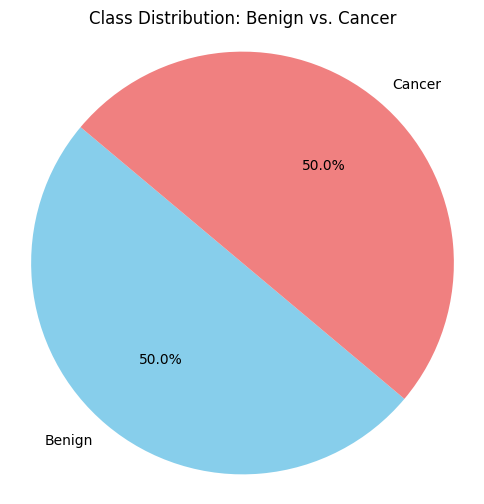

In [64]:
import matplotlib.pyplot as plt
import numpy as np

# Example counts (replace with your actual counts)
labels = ['Benign', 'Cancer']
counts = [5000, 5000]  # Or use np.bincount(y_train) if label array is available

# Plot
plt.figure(figsize=(6,6))
plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=140, colors=['skyblue', 'lightcoral'])
plt.title('Class Distribution: Benign vs. Cancer')
plt.axis('equal')  # Equal aspect ratio ensures pie is drawn as a circle.
plt.show()
